In [98]:
!pip install --verbose
!pip install --verbose pyvispoly

Using pip 24.1.2 from /usr/local/lib/python3.12/dist-packages/pip (python 3.12)
ERROR: You must give at least one requirement to install (see "pip help install")
Using pip 24.1.2 from /usr/local/lib/python3.12/dist-packages/pip (python 3.12)


# DCEL (extraída de Github)

In [99]:
import numpy as np
import math as m
from sortedcontainers import SortedList
from matplotlib import pyplot as plt
from collections import deque

# Para Polígono de Visibilidad
from pyvispoly import (
    FieldNumber,
    Point,
    Polygon,
    PolygonWithHoles,
    VisibilityPolygonCalculator,
    plot_polygon,
)

eps = 1e-9
sweepLineY = np.inf
diag_triangles = []

# Utils
def findHAngle(dx, dy):
    """Determines the angle with respect to the x axis of a segment
    of coordinates dx and dy
    """
    l = m.sqrt(dx*dx + dy*dy)
    if dy > eps:
        return m.acos(dx/l)
    else:
        return 2*m.pi - m.acos(dx/l)


class Vertex:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.hedges = []  # list of halfedges whose tail is this vertex
        self.poly_order = []
        self.color = 0

    def __eq__(self, other):
        if isinstance(other, Vertex):
            return self.x == other.x and self.y == other.y
        return NotImplemented

    def __lt__(self, other):
        if self.y == other.y:
            return self.x > other.x
        return self.y < other.y

    def sortHedges(self):
        self.hedges.sort(key=lambda a: a.angle, reverse=True)

    def __repr__(self):
        return "({0},{1})".format(self.x, self.y)

    def __hash__(self):
        return hash((self.x, self.y))

    def getTuple(self):
        return tuple([self.x,self.y])

    def set_poly_order(self):
        self.poly_order = [self.hedges[0].prev.tail, self.hedges[0].tail, self.hedges[0].next.tail]



class Hedge:
    # v1 -> v2
    def __init__(self, v1, v2):
        self.prev = None
        self.twin = None
        self.next = None
        self.tail = v1
        self.face = None
        if m.sqrt((v2.x-v1.x)**2 + (v2.y-v1.y)**2) == 0:
          print(v1, v2)
        self.angle = findHAngle(v2.x-v1.x, v2.y-v1.y)
        if v1 > v2:
            self.upper = v1
            self.lower = v2
        else:
            self.upper = v2
            self.lower = v1

    def __hash__(self):
        return hash((self.tail.x, self.tail.y, self.angle))

    def __eq__(self, other):
        return self.tail == other.tail and \
            self.next.tail == other.next.tail

    def sweepLineIntersection(self):
        global sweepLineY

        dy = self.upper.y - self.lower.y
        if abs(dy) < eps:
            return self.upper.x

        dx = self.upper.x - self.lower.x
        if abs(dx) < eps:
            return self.lower.x

        m = dy / dx
        b = self.upper.y - (m * self.upper.x)
        return (sweepLineY - b) / m

    def __lt__(self, other):
        x_self = self.sweepLineIntersection()
        x_other = other.sweepLineIntersection()
        if(x_self is None or x_other is None):
            return False
        return x_self < x_other

    def __repr__(self):
        if self.next is not None:
            return "({0},{1})->({2},{3})".format(self.tail.x, self.tail.y,
                                            self.next.tail.x,
                                            self.next.tail.y)
        else:
            return "({0},{1})->()".format(self.tail.x, self.tail.y)


class Face:
  def __init__(self):
    self.halfEdge = None
    self.name = None
    self.hedgeCount = 0

    def __hash__(self):
        return hash(self.name)


class DCEL:
  def __init__(self):
    self.vertices = []
    self.hedges = []
    self.faces = []

  # Returns vertex object given x and y
  def findVertex(self, x, y):
    for v in self.vertices:
      if v.x == x and v.y == y:
        return v
    return None

  # Returns Halfedge whole vertices are v1 and v2
  # v1 and v2 are tuples
  def findHalfEdge(self, v1, v2):
    for halfEdge in self.hedges:
      nextEdge = halfEdge.next
      if (halfEdge.tail.x == v1[0] and halfEdge.tail.y == v1[1]) and (nextEdge.tail.x == v2[0] and nextEdge.tail.y == v2[1]):
        return halfEdge

    return None

  def build_dcel(self, points, segments):

    #  For each point create a vertex and add it to vertices
    for point in points:
      self.vertices.append(Vertex(point[0], point[1]))

    # For each input segment, create to hedges and assign their
    # tail vertices and twins

    # Structures of segment is [(0, 5), (2, 5)]
    for segment in segments:
      startVertex = segment[0]
      endVertex = segment[1]

      v1 = self.findVertex(startVertex[0], startVertex[1])
      v2 = self.findVertex(endVertex[0], endVertex[1])

      h1 = Hedge(v1, v2)
      h2 = Hedge(v2, v1)

      h1.twin = h2
      h2.twin = h1

      v1.hedges.append(h1)
      v2.hedges.append(h2)

      self.hedges.append(h1)
      self.hedges.append(h2)

    # For each endpoint, sort the half-edges whose
    # tail vertex is that endpoint in clockwise order.

    for vertex in self.vertices:
      vertex.sortHedges()

      noOfHalfEdges = len(vertex.hedges)

      if noOfHalfEdges < 2:
        return Exception("Invalid DCEL. There should be at least two half edges for a vertex")

      # For every pair of half-edges e1, e2 in clockwise order,
      # assign e1->twin->next = e2 and e2->prev = e1->twin.
      for i in range(noOfHalfEdges - 1):
        e1 = vertex.hedges[i]
        e2 = vertex.hedges[i+1]

        e1.twin.next = e2
        e2.prev = e1.twin

      # for the last and first halfedges pair
      e1 = vertex.hedges[noOfHalfEdges - 1]
      e2 = vertex.hedges[0]

      e1.twin.next = e2
      e2.prev = e1.twin

    # For every cycle, allocate and assign a face structure.
    faceCount = 0
    for halfEdge in self.hedges:

      if halfEdge.face == None:
        faceCount += 1

        f = Face()
        f.name = "f" + str(faceCount)

        f.halfEdge = halfEdge
        halfEdge.face = f

        h = halfEdge
        while (not h.next == halfEdge):
          h.face = f
          h = h.next
        h.face = f

        self.faces.append(f)

    do = True
    currEdge = self.hedges[0]
    while do or currEdge != self.hedges[0]:
        do = False
        if(currEdge != currEdge.tail.hedges[0]):
          currEdge.tail.hedges.reverse()
        currEdge = currEdge.next

    for p in points:
        v = self.findVertex(p[0], p[1])
        v.set_poly_order()

    for face in self.faces:
      currface = face.halfEdge.next
      while(currface != face.halfEdge):
        face.hedgeCount += 1
        currface = currface.next
      face.hedgeCount += 1

# Funciones de Geometría

In [100]:
# ---------------- Checa si el ángulo es convexo con el producto cruz -----------------
def angle_is_convex(p, q, r):
  return ((q[0] - p[0]) * (r[1] - q[1]) - (q[1] - p[1]) * (r[0] - q[0])) > 0

# -------------------- Checa el sentido de cambio de tres puntos ----------------------
def change_sign(a, b, c):
  return (a[0] - c[0]) * (b[1] - c[1]) - (b[0] - c[0]) * (a[1] - c[1])

# ------ Calcula si un punto 'p' está dentro del triángulo formado por (a, b, c) ------
def is_inside(a, b, c, p):
  # Método de los signos baricéntricos
  sign_1 = change_sign(p, a, b)
  sign_2 = change_sign(p, b, c)
  sign_3 = change_sign(p, c, a)

  # Para que 'p' esté dentro debe cumplirse que cada 'sign' calculado
  # tenga el mismo signo que los demás
  negatives = (sign_1 < 0) or (sign_2 < 0) or (sign_3 < 0)
  positives = (sign_1 > 0) or (sign_2 > 0) or (sign_3 > 0)

  if negatives and positives:
    return False # Si existen signos contrarios no está dentro
  return True

# ------------------------ Checa si el vértice b es oreja o no ------------------------
def is_an_ear(a, b, c, poly):
  # Los vértices reflex se descartan como orejas
  if not angle_is_convex(a, b, c):
    return False

  # Después tenemos que checar cada vértice del polígono
  # para ver que no se encuentre dentro de la oreja propuesta
  for vtx in poly:
    if vtx == a or vtx == b or vtx == c:
      continue
    if is_inside(a, b, c, vtx):
      return False # No es oreja, entonces se descarta
  # Como no hubo ningún punto dentro del triángulo de interés,
  # este vértice b es en efecto una oreja
  return True

# Inicialización del Polígono

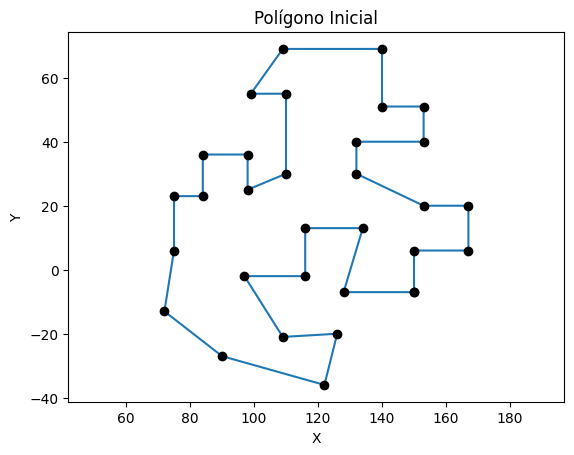

In [101]:
# ---------------------------- Declaración de Polígonos a Utilizar ----------------------------
poly_1 = [(0, 0), (2.5, 4), (10, 0), (10, 10), (5, 15), (7.5, 3), (0, 10)]
poly_2 = [(150 ,-7),(150 ,6),(167 ,6),(167 ,20),(153 ,20),(132 ,30),(132 ,40),(153 ,40),(153 ,51),(140 ,51),(140 ,69),
        (109, 69),(99 ,55),(110 ,55),(110 ,30),(98 ,25),(98 ,36),(84 ,36),(84 ,23),(75 ,23),(75 ,6),
        (72 ,-13), (90 ,-27) ,(122 ,-36),(126 ,-20),(109 ,-21),(97 ,-2),(116 ,-2),(116 ,13),(134 ,13),(128 ,-7)]
poly_3 = [(11, 8), (9, 9), (7, 7), (4, 8), (2, 10), (2, 7), (4, 5), (3, 2), (6, 4), (10, 1), (8, 6)]
poly_4 = [(0, 0), (2, 0), (2, 1), (1, 1), (1, 2), (0, 2)]
poly_5 = [(5, 9), (4.78, 6.41), (2,8), (1, 6), (2, 4), (1, 2), (3, 1), (5, 3), (4.14, 5.59), (7,5), (8,3), (6, 2), (6.02, 0.47), (9.08, 0.72),
          (9.30, 2.13), (11.63, 1.2), (8.34, 4.08), (11.26, 3.6), (10.48, 6.55), (7.77, 5.71), (8.77, 7.38), (9.17, 9.56)]

# Elegimos un Polígono
points = poly_2

# Construimos el vector de segmentos
segments = [[points[i], points[i + 1]] for i in range(len(points) - 1)]
segments.append([points[-1], points[0]])
n = len(segments)

# Graficamos para ver el polígono
x = [p[0] for p in points]
y = [p[1] for p in points]
x.append(x[0])
y.append(y[0])
plt.axis('equal')
plt.title("Polígono Inicial")
plt.xlabel("X")
plt.ylabel("Y")
plt.plot(x, y, marker='o', mec  = 'black', mfc = 'black')
plt.show()

# Ear Clipping

In [102]:
# Algoritmo para Triangular por "Ear Clipping"
def ear_clipping(vertices):
  global diag_triangles
  triangles = [] # Guarda la triangulación del polígono
  poly = vertices.copy()

  # Casos Triviales
  if len(poly) < 3: # Dos puntos
    return []
  if len(poly) == 3: # Se regresa el triángulo
    return [(poly[0], poly[1], poly[2])]

  # Se detiene cuando solo le queda 3 vértices por investigar
  while len(poly) > 3:
    exists_an_ear = False
    for i in range(len(poly)):
      prev_idx = (i + len(poly) - 1) % len(poly)
      next_idx = (i + 1) % len(poly)
      p1 = poly[prev_idx]
      p2 = poly[i]
      p3 = poly[next_idx]
      # Si encontramos una oreja, agregamos el triángulo a nuestro vector
      # y su diagonal correspondiente (esto para la DCEL)
      if is_an_ear(p1, p2, p3, poly):
        triangles.append((p1, p2, p3))
        diag_triangles.append([p1, p3])
        poly.pop(i) # Se borra el vértice 'oreja' para no considerarlo más
        exists_an_ear = True
        break
    if not exists_an_ear:
      return []
  triangles.append(tuple(poly)) # Se añade el último triángulo
  return triangles

# Visualización de la Triangulación

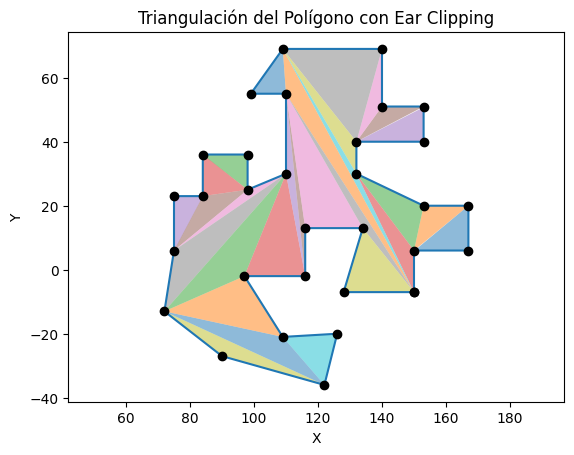

In [103]:
# Grafica la Triangulación del Polígono
def plot_ear_clipping(poly, triangles):
  x_coords, y_coords = zip(*poly)
  fig, ax = plt.subplots()
  ax.set_aspect('equal', adjustable='box') # Ajusta los ejes para que sean 1:1
  ax.set_xlabel("X")
  ax.set_ylabel("Y")
  # Se colorea cada triángulo de nuestra triangulación
  # para una mejor visualización
  for i, triangle in enumerate(triangles):
    ax.fill(*zip(*triangle), alpha=0.5)
  ax.set_title("Triangulación del Polígono con Ear Clipping")
  plt.axis('equal')
  plt.plot(x_coords,y_coords, marker='o', mec  = 'black', mfc = 'black')
  plt.show()

diag_triangles = []
points = points.copy()
# Se añade el primer punto de nuevo al vector para que termine de cerrarse
points.append(points[0])
t_Poly = ear_clipping(points)
plot_ear_clipping(points, t_Poly)

# Generamos el vector de segmentos (aristas del polígono)
segments = [[points[i], points[i + 1]] for i in range(len(points) - 1)]

# Coloración de un Polígono y Colocación de Guardias

In [104]:
# Hace la 3-coloración con las caras del grafo de la DCEL con colores [1,2,3]
def vertices_color(face, colors):
  current_v = face.halfEdge
  # Paramos hasta llegar a un vértice sin color
  while current_v.tail.color != 0:
    current_v = current_v.next
  # Asignamos un color a dicho vértice
  current_v.tail.color = 6 - current_v.prev.tail.color - current_v.next.tail.color
  colors[current_v.tail.color - 1] += 1 # Aumentamos la cantidad de nodos coloreados.

# Inicializamos el DCEL
segments_graph = segments + diag_triangles
graph = DCEL()
# Como anteriormente agregamos el primer nodo al final de 'points'
# no lo consideramos ahora.
graph.build_dcel(points[:-1], segments_graph)

# Quitamos la cara exterior del conjunto 'faces' de nuestro grafo
for face in graph.faces:
  if face.hedgeCount >= n:
    outerFaceName = face.name
  else:
    firstFace = face

# DFS para la Coloración

In [105]:
# Iniciamos la DFS con la cara de inicio
visited = set()
DFS = deque()
DFS.append(firstFace)
colors = [1, 1, 1] # Colores []

while len(DFS) > 0:
  current_face = DFS.pop()
  # Si no se ha visitado una cara, la visitamos
  if current_face not in visited and current_face.name != outerFaceName:
    visited.add(current_face)
    # Coloreamos a los primeros vértices del 1er triángulo
    if current_face == firstFace:
      current_face.halfEdge.tail.color = 1
      current_face.halfEdge.prev.tail.color = 2
      current_face.halfEdge.next.tail.color = 3
    else:
      # Si no son los primeros, se hace la coloración para el polígono
      vertices_color(current_face, colors)
    DFS.append(current_face.halfEdge.twin.face)
    DFS.append(current_face.halfEdge.next.twin.face)
    DFS.append(current_face.halfEdge.prev.twin.face)

# Color de los guardias mínimos para la buena cobertura en la galería
color_guards = np.argmin(np.array(colors)) + 1

## Visualización de la 3-coloración

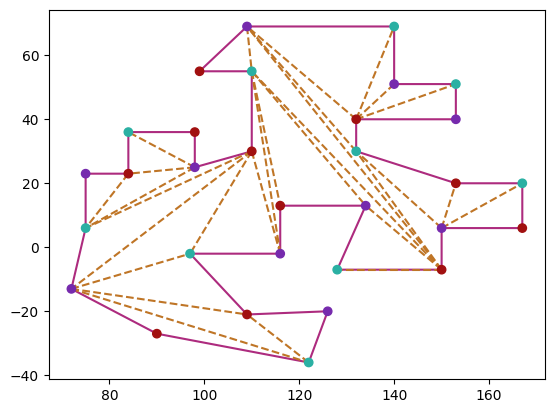

In [106]:
# Definir colores y coordenadas de la coloración
colorVertices_graph = [p.color for p in graph.vertices]
colorVertices_arr = ["#762aad", "#a11010", "#2ab0a3"]
x = [p.x for p in graph.vertices]
y = [p.y for p in graph.vertices]

# Graficar todo
final_color = [colorVertices_arr[p-1] for p in colorVertices_graph]
plt.scatter(x, y, marker='o', color = final_color, zorder=10)

x.append(x[0])
y.append(y[0])
plt.plot(x, y, color = "#ad2b7e")

for line in diag_triangles:
    plt.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], '--', color = '#bf7526')

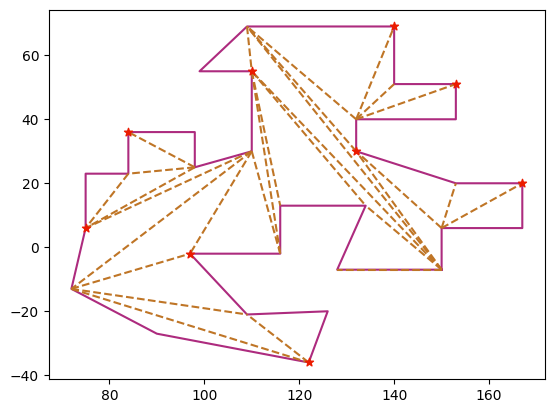

In [107]:
names = ['#f72585', '#9d4edd', '#3a0ca3']

guards_x = [p.x for p in graph.vertices if p.color == color_guards]
guards_y = [p.y for p in graph.vertices if p.color == color_guards]
plt.scatter(guards_x, guards_y, marker='*', color = "#eb1b00", zorder=5)

x = [p.x for p in graph.vertices]
y = [p.y for p in graph.vertices]

x.append(x[0])
y.append(y[0])
plt.plot(x, y, color = "#ad2b7e")

for line in diag_triangles:
    plt.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], '--', color =  '#bf7526')

# Polígono de Visibilidad

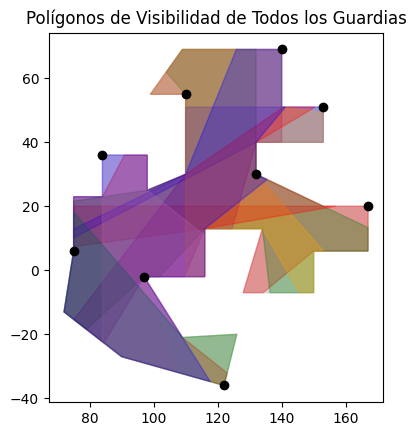

In [109]:
poly1_vis =  PolygonWithHoles(
    [Point(0, 0), Point(2.5, 4), Point(10, 0), Point(10, 10), Point(5, 15), Point(7.5, 3), Point(0, 10)],
    [],
)
poly2_vis = PolygonWithHoles(
    [Point(150 ,-7),Point(150 ,6),Point(167 ,6),Point(167 ,20),Point(153 ,20),Point(132 ,30),Point(132 ,40),Point(153 ,40),Point(153 ,51),Point(140 ,51),Point(140 ,69),
        Point(109, 69),Point(99 ,55),Point(110 ,55),Point(110 ,30),Point(98 ,25),Point(98 ,36),Point(84 ,36),Point(84 ,23),Point(75 ,23),Point(75 ,6),
        Point(72 ,-13), Point(90 ,-27) ,Point(122 ,-36),Point(126 ,-20),Point(109 ,-21),Point(97 ,-2),Point(116 ,-2),Point(116 ,13),Point(134 ,13),Point(128 ,-7)],
    [],
)
poly3_vis =  PolygonWithHoles(
    [Point(11, 8), Point(9, 9), Point(7, 7), Point(4, 8), Point(2, 10), Point(2, 7), Point(4, 5), Point(3, 2), Point(6, 4), Point(10, 1), Point(8, 6)],
    [],
)
poly4_vis =  PolygonWithHoles(
    [Point(0, 0), Point(2, 0), Point(2, 1), Point(1, 1), Point(1, 2), Point(0, 2)],
    [],
)
poly5_vis =  PolygonWithHoles(
    [Point(5, 9), Point(4.78, 6.41), Point(2,8), Point(1, 6), Point(2, 4), Point(1, 2), Point(3, 1), Point(5, 3), Point(4.14, 5.59), Point(7,5), Point(8,3), Point(6, 2), Point(6.02, 0.47), Point(9.08, 0.72),
          Point(9.30, 2.13), Point(11.63, 1.2), Point(8.34, 4.08), Point(11.26, 3.6), Point(10.48, 6.55), Point(7.77, 5.71), Point(8.77, 7.38), Point(9.17, 9.56)],
    [],
)
poly_vis = poly2_vis

# Initialize a single figure and axes for all visibility polygons
fig, ax = plt.subplots()
ax.set_aspect("equal")
plt.title("Polígonos de Visibilidad de Todos los Guardias")
plot_polygon(poly_vis, ax=ax, color="lightgrey")
colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink']

# Se calcula el polígono de visibilidad para cada guardia
for i, (x, y) in enumerate(zip(guards_x, guards_y)):
  visp_poly_calc = VisibilityPolygonCalculator(poly_vis)
  vis_poly = visp_poly_calc.compute_visibility_polygon(Point(x, y))

  plt.plot([x], [y], 'o', color='black') # Plot guard position
  plot_polygon(vis_poly, ax=ax, color=colors[i % len(colors)], alpha=0.3)

# Save and show the combined figure once
plt.savefig("/content/visibility_polygon_all_guards.png")
plt.show()